In [2]:
# Let's import the needed packages

# Find the El Nino peaks in the signal
from scipy.signal import find_peaks

# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot the Nino 3.4 index
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# To plot the map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# To perform the ML technics using sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import useful_functions

# 0. Useful functions

In [3]:
# def get_data(Path):
#     """
#     Path: Path of the preprocessed data you want to get
#     """
#     data = np.load(Path)
#     # Get the variables
#     #print(data.files)
#     X = data["X"]
#     y = data["y"]

#     # Check dimensions
#     print('==== GET THE DATA ====')
#     print("Shape of X:", X.shape)
#     print("Shape of y:", y.shape)

#     print("First 25 elements of y:", y[:25])
#     return(X,y)


In [4]:
# def split_scale_data(X, y, RANDOM_SPLIT=False, train_size=374, verbose=True):
#     """
#     X, y: Inputs and outputs
#     RANDOM_SPLIT: Boolean, if False splits for train and test are done in in time order, if True, splits are random
#     train_size: number of data in the train sample (test_size=474 - train_size)
#     verbose: if True, the function prints information about the shape of the outputs data sets
#     """
#     # Split the data
#     if RANDOM_SPLIT:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
#     else:
#         X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

#     # Introduce a scaler
#     scaler = StandardScaler()
#     scaler.fit(X_train)
#     # Standardize the train and test data
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)

#     # Check dimensions
#     if verbose:
#         print("==== SPLIT & SCALE THE DATA ====")
#         print("Shape of X_train:", X_train.shape)
#         print("Shape of y_train:", y_train.shape)
#         print("Shape of X_test:", X_test.shape)
#         print("Shape of y_test:", y_test.shape)

#     return(X_train, X_test, y_train, y_test)


# 1. One-month prediction

In [5]:
# Get the data for a 1-month prediction, split and scale the data
X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT=False, train_size=374)

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1.1. Baseline n°1 - LDA

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, accuracy_score

In [7]:
# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred_lda)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 0.984
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.947


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

#### Dimensionality reduction: PCA

In [7]:
# Data path
sst_data_path = 'data/sst.mnmean.nc'

# Upload the data under a xr array format
sst_ds = xr.load_dataset(sst_data_path)
sst = sst_ds["sst"]

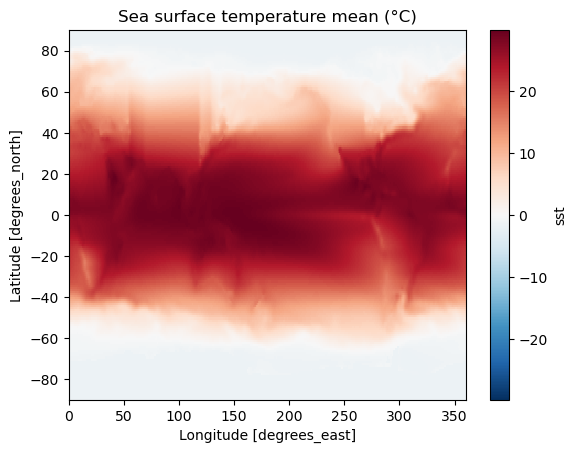

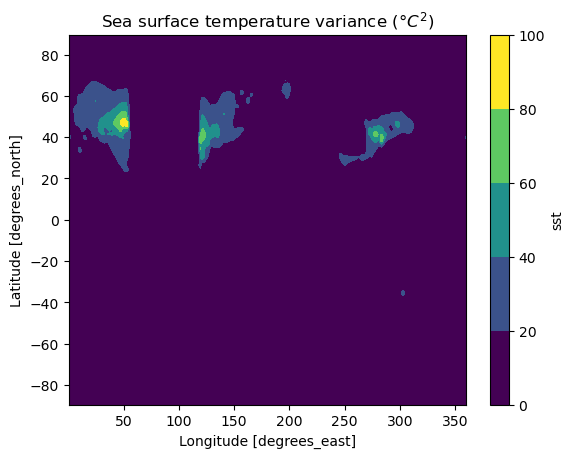

In [8]:
# Compute the mean
sst_mean = sst.mean('time') # axis = 0 to compute the mean on the time

# Plot mean per grid point with pcolormesh
plt.figure()
sst_mean.plot()
plt.title(r'Sea surface temperature mean (°C)')

# Compute deviations from the mean
sst_dev = sst - sst_mean

# Compute the variance
sst_var = sst_dev.var('time')

# Plot variance per grid point with contourf
plt.figure()
sst_var.plot.contourf()
_ = plt.title(r'Sea surface temperature variance (°$C^2$)')

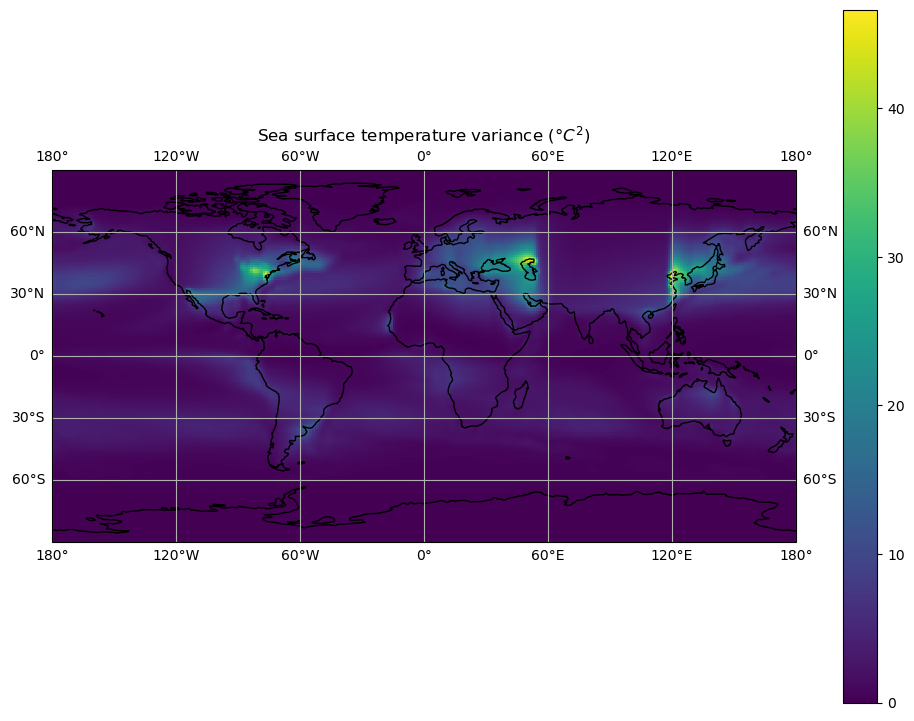

In [9]:
# Get grid-point area coefficients
coef = np.cos(np.deg2rad(sst['lat']))

# Scale height by coefficient
sst_scaled = sst_dev * coef

# Plot scaled variance with costlines and gridlines
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = sst_scaled.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Sea surface temperature variance (°$C^2$)')

C'est bizarre ces températures non ?

C:\Users\natha\AppData\Local\Temp\ipykernel_8800\1272885581.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


<Figure size 640x480 with 0 Axes>

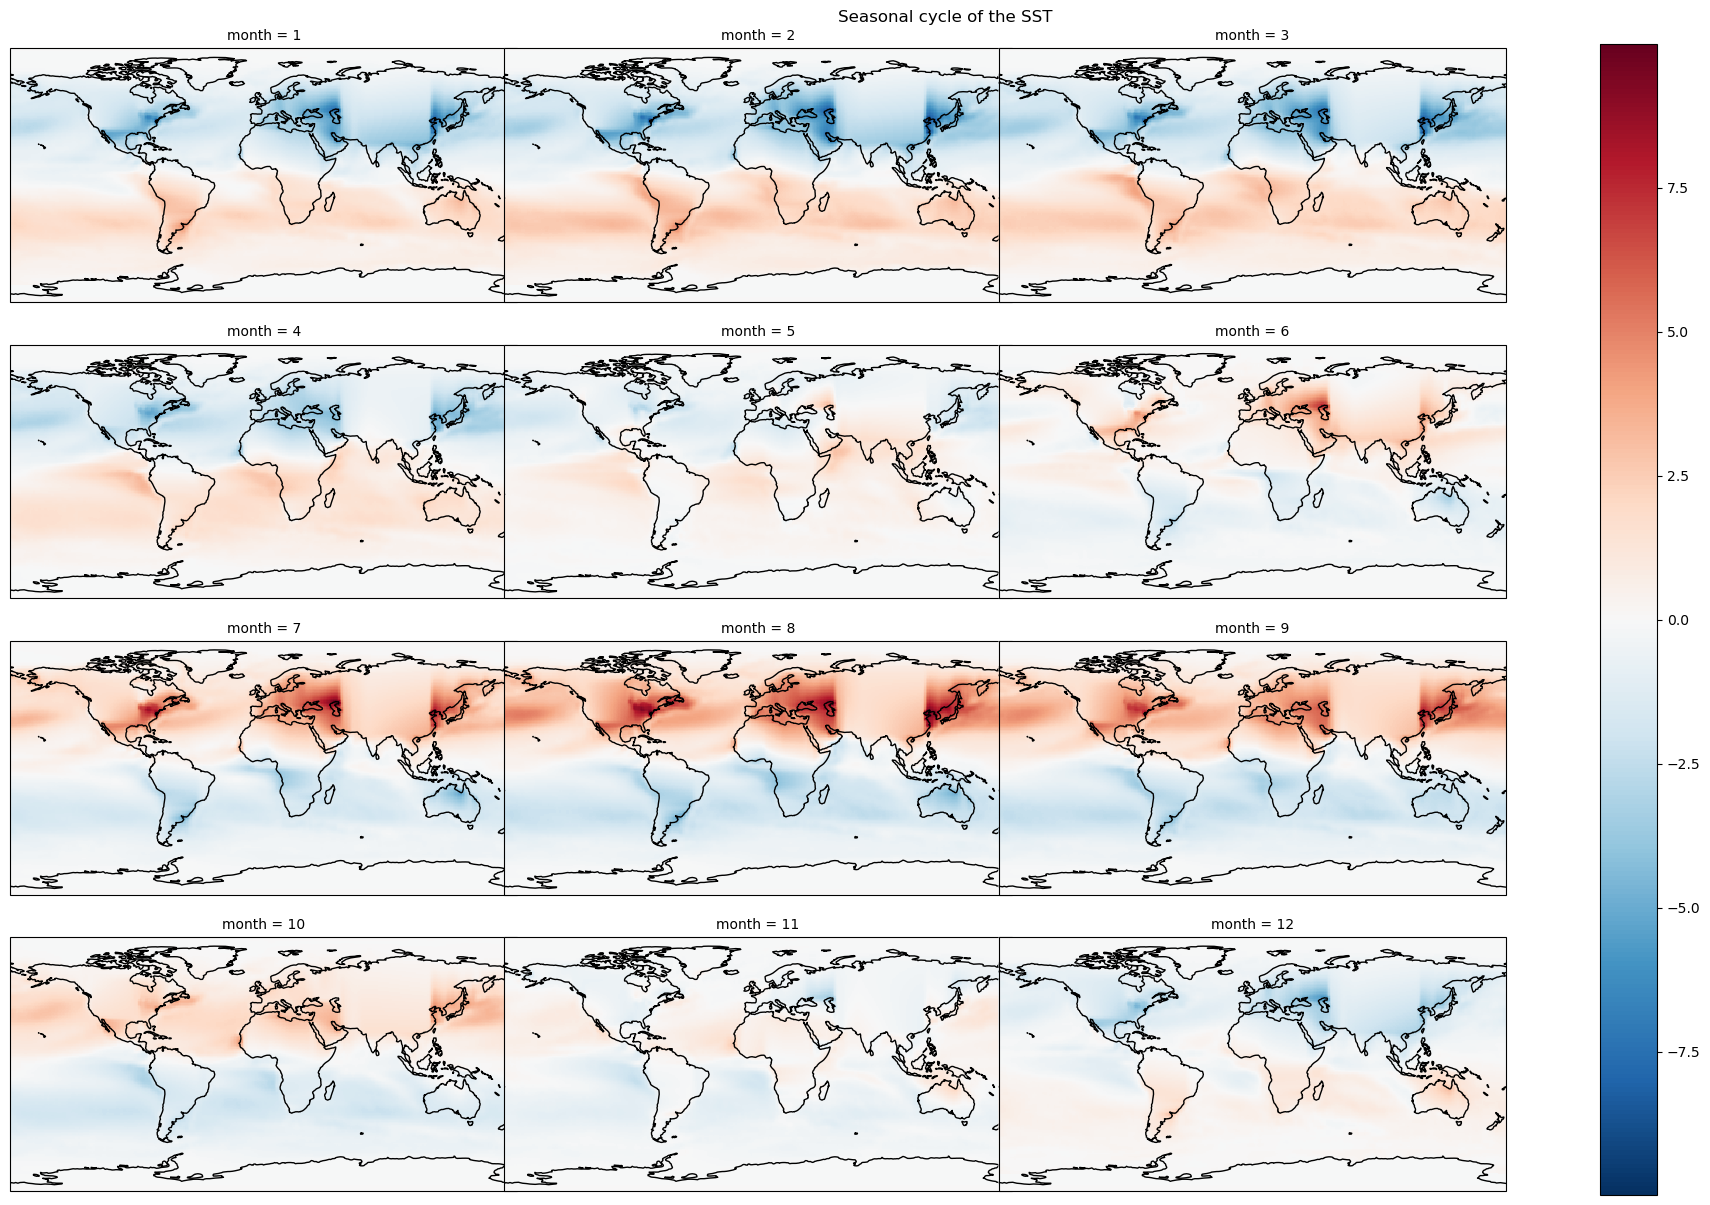

In [10]:
# Compute monthly seasonal cycle
gps = sst_scaled.groupby('time.month')

# Get seasonal cycle
sst_seasonal = gps.mean()

# Plot each month of seasonal cycle
fig = plt.figure()
col_wrap = 3
g = sst_seasonal.plot(x='lon', y='lat', col='month', col_wrap=col_wrap,
                     subplot_kws=dict(projection=ccrs.PlateCarree()),
                     aspect=2)
for ax in g.axes.flat:
    ax.coastlines()
_ = plt.suptitle('Seasonal cycle of the SST', y=1)

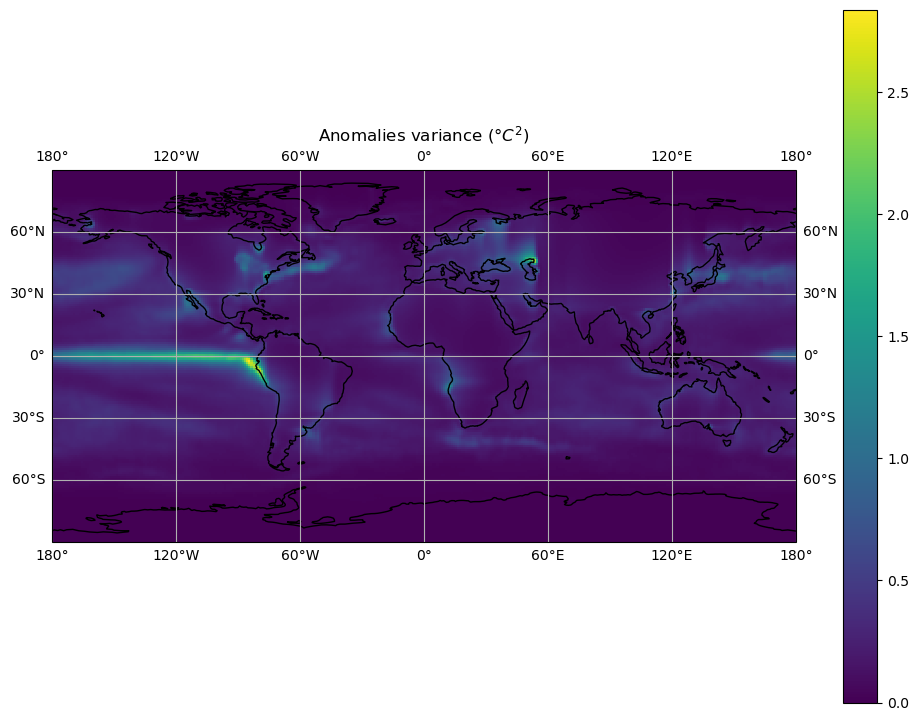

In [11]:
# Get seasonal anomalies
sst_anom = sst_scaled.groupby('time.month') - sst_seasonal

# Plot variance of the seasonal anomalies on a map
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = sst_anom.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Anomalies variance (°$C^2$)')

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

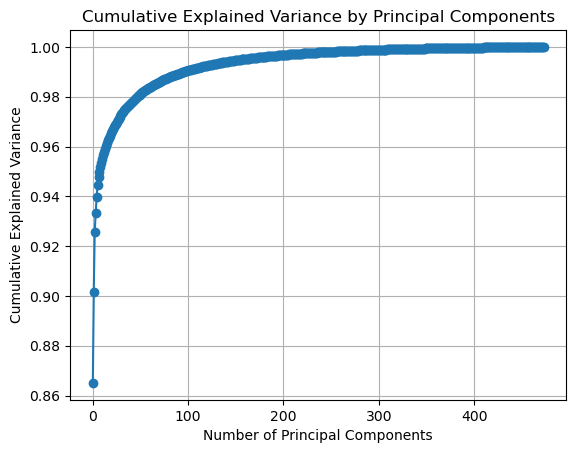

In [12]:
# PCA
PCA_sst = PCA(n_components=None)
PCA_sst.fit(X)
# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_
# plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [13]:
cum_variance_2_components = np.sum(explained_variance_ratio_sst[:1])
print("Cumulative variance projected in p=2 dimensions: "+str(100*cum_variance_2_components)+" %")

Cumulative variance projected in p=2 dimensions: 86.50529980659485 %


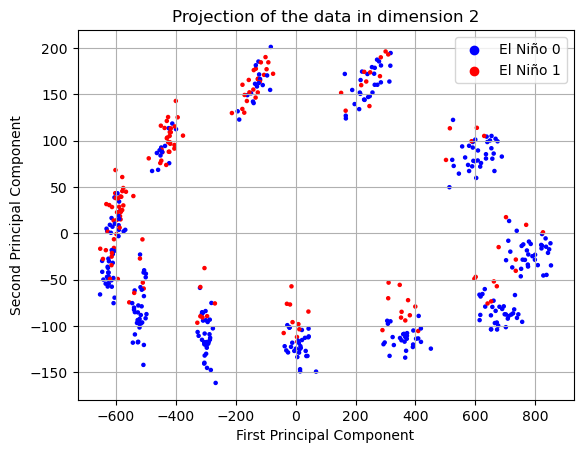

In [37]:
colors = {0: 'blue', 1: 'red'}
scatter_colors = [colors[el_nino] for el_nino in y]

# PCA with p=2
PCA_sst = PCA(n_components=2)
PCA_sst.fit(X)
# fit the model and project in 2D
Xp_sst = PCA_sst.transform(X)
# plot the data in dimension 2
plt.scatter(Xp_sst[:, 0], Xp_sst[:, 1],s=5, c=scatter_colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("Projection of the data in dimension 2")
for el_nino, color in colors.items():
    plt.scatter([], [], color=color, label='El Niño '+ str(el_nino))
plt.legend()
plt.grid()

We can see that the clusters are not well separable. Thus, we need to add another dimension.

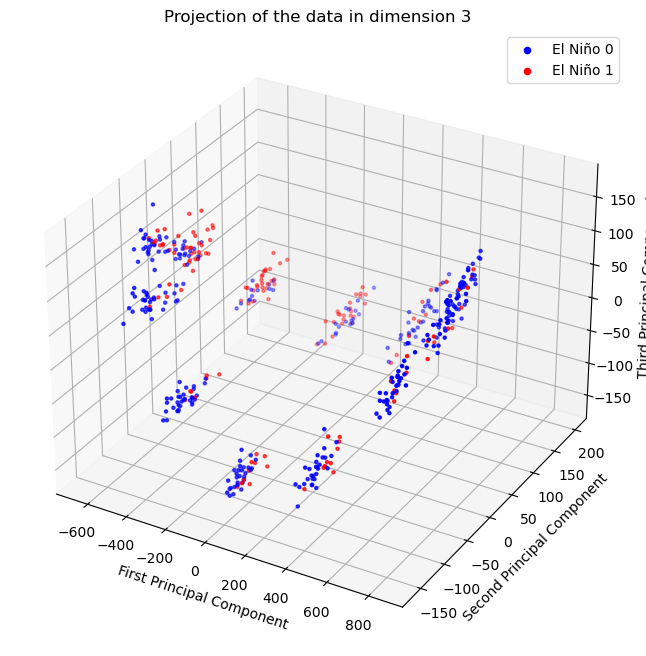

In [15]:
from mpl_toolkits.mplot3d import Axes3D  # Import nécessaire pour les graphiques 3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define the color
colors = {0: 'blue', 1: 'red'}
scatter_colors = [colors[el_nino] for el_nino in y]

# PCA with p=3
PCA_sst = PCA(n_components=3)
PCA_sst.fit(X)

# fit the model and project in 3D
Xp_sst = PCA_sst.transform(X)

# Scatter plot en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xp_sst[:, 0], Xp_sst[:, 1], Xp_sst[:, 2], s=5, c=scatter_colors)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title("Projection of the data in dimension 3")
# Add a legend
for el_nino, color in colors.items():
    ax.scatter([], [], [], color=color, label='El Niño '+ str(el_nino))
ax.legend()
plt.grid()

Let us perform LDA on the new data in dimension 3.

In [16]:
# PCA avec 3 composantes principales
PCA_sst = PCA(n_components=5)
PCA_sst.fit(X)

# Projeter les données dans l'espace 3D
Xp_sst = PCA_sst.transform(X)

In [17]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # To know the p value considered
    print("p=",p)

    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = split_scale_data(Xp_sst, y, RANDOM_SPLIT=False, train_size=374, verbose=False)

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred_lda = lda.predict(X_test)
    y_train_pred_lda = lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred_lda))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred_lda))



p= 1
p= 2
p= 3
p= 4
p= 5
p= 6
p= 7
p= 8
p= 9
p= 10
p= 11
p= 12
p= 13
p= 14
p= 15
p= 16
p= 17
p= 18
p= 19
p= 20
p= 21
p= 22
p= 23
p= 24
p= 25
p= 26
p= 27
p= 28
p= 29
p= 30
p= 31
p= 32
p= 33
p= 34
p= 35
p= 36
p= 37
p= 38
p= 39
p= 40
p= 41
p= 42
p= 43
p= 44
p= 45
p= 46
p= 47
p= 48
p= 49
p= 50
p= 51
p= 52
p= 53
p= 54
p= 55
p= 56
p= 57
p= 58
p= 59
p= 60
p= 61
p= 62
p= 63
p= 64
p= 65
p= 66
p= 67
p= 68
p= 69
p= 70
p= 71
p= 72
p= 73
p= 74
p= 75
p= 76
p= 77
p= 78
p= 79
p= 80
p= 81
p= 82
p= 83
p= 84
p= 85
p= 86
p= 87
p= 88
p= 89
p= 90
p= 91
p= 92
p= 93
p= 94
p= 95
p= 96
p= 97
p= 98
p= 99
p= 100


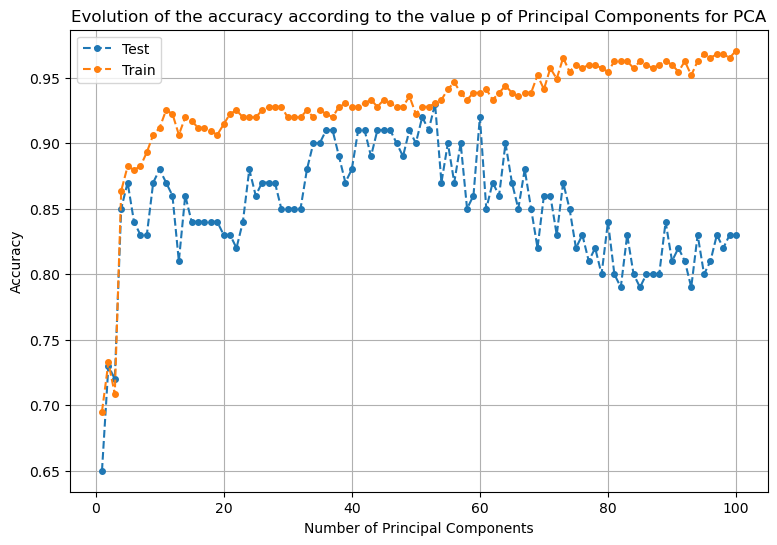

In [18]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

In [36]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"BEST VALUE FOR P - PCA : {best_p_value}")
print(f"BEST TRAIN SCORE : {best_train_score_pca}")
print(f"BEST TEST SCORE : {best_test_score_pca}")

BEST VALUE FOR P - PCA : 53
BEST TRAIN SCORE : 0.93048128342246
BEST TEST SCORE : 0.93


#### Dimensionality reduction: T-SNE

It appears that the data are difficult to separate linearly. We will try another dimensionality reduction method and compare it with the results of PCA.

In [30]:
from sklearn.manifold import TSNE

In [ ]:
# PCA with p=2
PCA_sst = PCA(n_components=2)
PCA_sst.fit(X)
# fit the model and project in 2D
Xp_sst = PCA_sst.fit_transform(X)
# plot the data in dimension 2
plt.scatter(Xp_sst[:, 0], Xp_sst[:, 1],s=5, c=scatter_colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("Projection of the data in dimension 2")
for el_nino, color in colors.items():
    plt.scatter([], [], color=color, label='El Niño '+ str(el_nino))
plt.legend()
plt.grid()

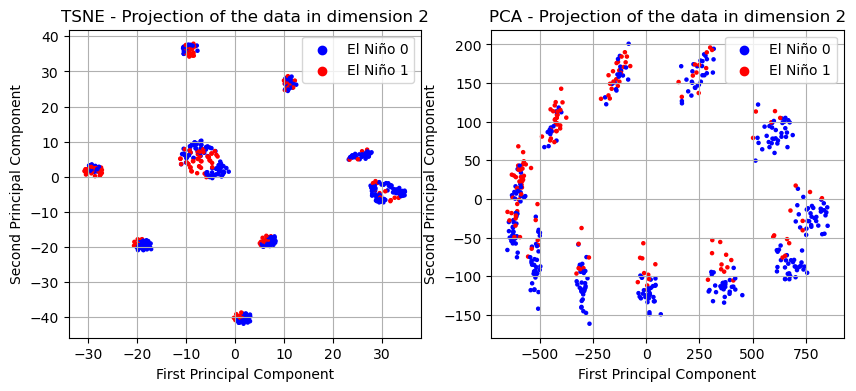

In [45]:
# TSNE
TSNE_sst = TSNE(n_components=2, perplexity=30) # default parameters
Xtsne_sst =TSNE_sst.fit_transform(X)

# PCA
PCA_sst = PCA(n_components=2)
PCA_sst.fit(X)
Xp_sst = PCA_sst.fit_transform(X)


# plot the data in dimension 2 for TSNE
colors = {0: 'blue', 1: 'red'}
scatter_colors = [colors[el_nino] for el_nino in y]

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.scatter(Xtsne_sst[:, 0], Xtsne_sst[:, 1],s=5, c=scatter_colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("TSNE - Projection of the data in dimension 2")
for el_nino, color in colors.items():
    plt.scatter([], [], color=color, label='El Niño '+ str(el_nino))
plt.legend()
plt.grid()
 # plot the date in dimension 2 for PCA
plt.subplot(1,2,2)
plt.scatter(Xp_sst[:, 0], Xp_sst[:, 1],s=5, c=scatter_colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA - Projection of the data in dimension 2")
for el_nino, color in colors.items():
    plt.scatter([], [], color=color, label='El Niño '+ str(el_nino))
plt.legend()
plt.grid()

## 1.2. Baseline n°2 - OLS

In [ ]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression